In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from GmGM import Dataset, GmGM
from strong_product_model import strong_product_model
from utilities import vec_kron_sum, sim_diag
import random
import BiGLasso_Methods as bg
from typing import Literal
from sklearn.metrics import auc
from collections import OrderedDict

SEED = 0

# Make palette colorblind friendly
plt.style.use('tableau-colorblind10')
hatches = ['|', '//', 'oo', 'x', '+', '-', 'OO', '.', '*', '\\']
lines = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5))]

# Prevent type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def fast_strong_product(
    Psi_1: np.ndarray,
    Psi_2w: np.ndarray,
    Psi_2b: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Theta = Psi_2b + np.eye(Psi_2b.shape[0])
    P, D = sim_diag(Theta, Psi_2w)
    Lam, V = np.linalg.eigh(Psi_1)
    core = 1 / vec_kron_sum([Lam, D])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2w.shape[0])
    z *= np.sqrt(core)
    Z = V @ z.reshape(Psi_1.shape[0], Psi_2w.shape[0]) @ np.linalg.inv(P)

    return Z

fast_strong_product(np.eye(5), np.eye(7), np.eye(7))
    

array([[ 0.7694989 ,  0.35996332,  0.00706134, -0.23276478,  0.53715887,
         0.54832909, -0.56927035],
       [-0.44573185, -0.38090686,  0.19617201,  0.15863608, -0.63112725,
         0.43264934,  0.4455695 ],
       [ 0.02887427,  0.49748525, -0.23644013, -0.37086668,  0.49262962,
        -0.83922306, -0.09730842],
       [-0.89059486, -0.04629446, -0.3110418 ,  0.53670651,  0.16899512,
        -0.44699458, -0.24741806],
       [ 0.30934498,  0.21673069,  0.74677993,  0.22443109,  1.52434773,
         0.59280845, -0.0191025 ]])

In [4]:
def fast_kronecker_sum_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / vec_kron_sum([Lam1, Lam2])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= np.sqrt(core)
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_sum_model(np.eye(5), np.eye(7))
    

array([[-1.22821862, -0.14170115, -0.40091557, -0.72759139,  1.46579037,
         0.00414905, -0.72982895],
       [ 1.1107962 , -0.87367094,  1.13656275,  0.10634516, -0.08407051,
         1.61180861, -0.52531232],
       [ 0.30429274,  0.68122013, -0.53766008,  0.24536571,  0.56210033,
         0.15248366, -0.12252135],
       [ 0.21104371,  0.19753261,  0.36114312, -0.14117023, -1.42543413,
         1.02876659,  1.03501392],
       [-0.22635181, -0.17573179,  0.37968556,  0.59058758,  0.0909265 ,
        -0.01419272,  0.53292449]])

In [5]:
def fast_kronecker_product_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / np.kron(Lam1, Lam2)

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= np.sqrt(core)
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_product_model(np.eye(5), np.eye(7))
    

array([[-0.43362   ,  1.8786331 ,  0.40766645, -0.31702219,  0.87507673,
         0.66563561, -0.21414297],
       [-0.13110294, -0.02664785,  0.17187161, -0.43026352, -0.03828997,
         1.60888064,  1.47548513],
       [ 0.64550505, -0.53362202,  1.05650446, -0.14133379, -1.06698891,
         1.59638378, -0.21155122],
       [ 0.18632554,  0.49846852, -0.49167432, -0.12476665, -0.67269823,
         0.70790905,  0.09209828],
       [-2.11747778,  1.86456866,  1.69471685, -1.6885507 , -1.1292901 ,
         0.36969392,  3.25829362]])

In [6]:
def pr_curve(
    ground_truth: np.ndarray,
    output: np.ndarray,
    num_points: int = 1000
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(num_points)
    recalls = np.zeros(num_points)
    thresholds = np.linspace(-0.1, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    if (output == np.eye(output.shape[0])).all():
        return None, None

    # Iterate over thresholds
    for i, threshold in enumerate(thresholds):
        # Threshold output
        output_thresholded = (output > threshold).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

def pr_curve_alg(
    ground_truth: np.ndarray,
    alg: callable,
    reg_params: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(reg_params.shape[0])
    recalls = np.zeros(reg_params.shape[0])
    #thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over reg_params
    for i, param in enumerate(reg_params):
        # Threshold output
        print(f"TeraLasso lambda: {param}")
        output = alg(param)
        output_thresholded = (output != 0).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

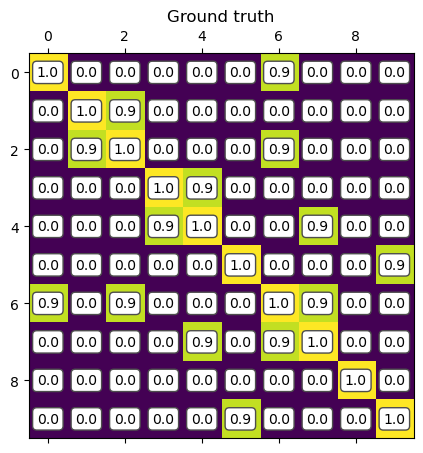

In [7]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(ground_truth)
ax1.set_title("Ground truth")

for (i, j), z in np.ndenumerate(ground_truth):
    ax1.text(
        j,
        i,
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
    )

In [8]:
# Create a random graph
def random_graph(graph):
    ground_truth = np.array(graph.get_adjacency().data)
    gt_sums = 1 / np.sqrt(ground_truth.sum(axis=0))
    ground_truth = gt_sums.reshape(1, -1) * ground_truth * gt_sums.reshape(-1, 1)

    # Add diagonal so that it forms a PSD matrix!
    ground_truth = ground_truth / 1.1 + np.eye(num_nodes)
    return ground_truth

def precision_test(
    num_nodes: int,
    graphs: list[ig.Graph],
    title: str,
    num_trials: int = 10,
    model: Literal[
        "Strong Product",
        "Kronecker Sum",
        "Kronecker Product"
    ] = "Strong Product",
    cb_cw_ratio: float = 1.0
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(SEED)
    np.random.seed(SEED)
    
    ground_truth_r = random_graph(graphs[0])
    ground_truth_cw = random_graph(graphs[1]) / np.sqrt(cb_cw_ratio)
    ground_truth_cb = np.sqrt(cb_cw_ratio) * random_graph(graphs[2])

    if model == "Strong Product":
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 7))
    elif model == "Kronecker Product":
        fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(10, 7))
        ax2 = None
    elif model == "Kronecker Sum":
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 7))
        ax3 = None


    algorithms = (
        [
            "Strong Product",
            "GmGM",
            "Strong Product [Kronecker Sum]",
            "Strong Product [Kronecker Product]",
            #"TeraLasso",
        ]
    )
    for idx, algorithm in enumerate(algorithms):
        print(f"Running {algorithm}")
        ps_r = []
        rs_r = []
        ps_cw = []
        rs_cw = []
        ps_cb = []
        rs_cb = []

        for i in range(num_trials):
            print(f"\tTrial {i+1} of {num_trials}")

            # Generate data
            #dfs = num_nodes
            #data_dependencies = stats.wishart(df=dfs, scale=np.eye(num_nodes)).rvs()
            #data_dependencies /= dfs
            if model == "Strong Product":
                output = fast_strong_product(
                    ground_truth_r,
                    ground_truth_cw,
                    ground_truth_cb
                )
            elif model == "Kronecker Sum":
                output = fast_kronecker_sum_model(
                    ground_truth_r,
                    ground_truth_cw
                )
            elif model == "Kronecker Product":
                output = fast_kronecker_product_model(
                    ground_truth_r,
                    ground_truth_cb
                )
            else:
                raise Exception(f"Unknown model: {model}")

            dataset = Dataset(
                dataset={"data": output[np.newaxis, :, :]},
                structure={"data": ("", "rows", "columns")}
            )
            result = None
            run_alg = None
            if algorithm == "GmGM":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = np.eye(num_nodes)
                        self.precision_matrices["cols_within_rows"] = precmats["columns"]
                result = GmGM(
                    dataset,
                    to_keep=0.5,
                    threshold_method="statistical-significance",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                result = result_container(result.precision_matrices)
            elif algorithm == "Strong Product":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3
                )
                result = result_container(result)
            elif algorithm == "Strong Product [Kronecker Sum]":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3,
                    fix_Theta=True
                )
                result = result_container(result)
            elif algorithm == "Strong Product [Kronecker Product]":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3,
                    fix_Psi_2w=True
                )
                result = result_container(result)
            elif algorithm == "TeraLasso":
                def alg(reg_param):
                    return bg.TeraLasso(
                        dataset,
                        reg_param,
                        use_nonparanormal_skeptic=False
                    ).precision_matrices["rows"].toarray()
                run_alg = alg
            else:
                raise Exception(f"Unknown algorithm: {algorithm}")

            if run_alg is None:
                if hasattr(result.precision_matrices["rows"], 'toarray'):
                    result.precision_matrices["rows"] = result.precision_matrices["rows"].toarray()
                if hasattr(result.precision_matrices["cols_within_rows"], 'toarray'):
                    result.precision_matrices["cols_within_rows"] = \
                        result.precision_matrices["cols_within_rows"].toarray()
                if hasattr(result.precision_matrices["cols_between_rows"], 'toarray'):
                    result.precision_matrices["cols_between_rows"] = \
                        result.precision_matrices["cols_between_rows"].toarray()
                ys_r, xs_r = pr_curve(ground_truth_r, result.precision_matrices["rows"])
                ys_cw, xs_cw = pr_curve(ground_truth_cw, result.precision_matrices["cols_within_rows"])
                ys_cb, xs_cb = pr_curve(ground_truth_cb, result.precision_matrices["cols_between_rows"])
            else:
                # Manually chosen bounds to cover span from ~perfect recall to ~perfect precision
                if algorithm == "TeraLasso":
                    reg_params = 10**np.linspace(-2, 0, 25)
                ys_r, xs_r = pr_curve_alg(ground_truth_r, run_alg, reg_params)
                ys_cw, xs_cw = pr_curve_alg(ground_truth_cw, run_alg, reg_params)
                ys_cb, xs_cb = pr_curve_alg(ground_truth_cb, run_alg, reg_params)
                #print(ys, xs)
            
            if ys_r is not None and xs_r is not None:
                ps_r.append(ys_r)
                rs_r.append(xs_r)
            if ys_cw is not None and xs_cw is not None:
                ps_cw.append(ys_cw)
                rs_cw.append(xs_cw)
            if ys_cb is not None and xs_cb is not None:
                ps_cb.append(ys_cb)
                rs_cb.append(xs_cb)


        num_points = 100
        xs = np.linspace(0, 1, num_points)

        if algorithm == "GmGM":
            label = "GmGM"
        elif algorithm == "TeraLasso":
            label = "TeraLasso"
        elif algorithm == "Strong Product":
            label = "Strong Product"
        elif algorithm == "Strong Product [Kronecker Sum]":
            label = "Kronecker Sum"
        elif algorithm == "Strong Product [Kronecker Product]":
            label = "Kronecker Product"
        else:
            raise Exception(f"Unknown algorithm: {algorithm}")

        if algorithm == "TeraLasso":
            # Tableau color is too light
            lineplot = ax1.plot(-1, -1, color='#888888')
        elif algorithm == "TeraLasso + mean estimation":
            lineplot = ax1.plot(-1, -1, color='#990000')
        else:
            lineplot = ax1.plot(-1, -1)
        xs = np.linspace(0.01, 1, 100)

        for ps, rs, ax in zip([ps_r, ps_cw, ps_cb], [rs_r, rs_cw, rs_cb], [ax1, ax2, ax3]):
            if ax is None:
                continue
            min_ys = np.zeros(100) + 1
            max_ys = np.zeros(100)
            if len(ps) == 0:
                continue
            for p, r in zip(ps, rs):
                f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
                min_ys = np.minimum(min_ys, f(xs))
                max_ys = np.maximum(max_ys, f(xs))
                #plt.plot(xs, f(xs), color='black', alpha=0.1)
            ax.plot(
                xs,
                min_ys,
                color=lineplot[0].get_color(),
                linestyle=lines[idx],
                alpha=0.3
            )
            ax.plot(
                xs,
                max_ys,
                color=lineplot[0].get_color(),
                linestyle=lines[idx],
                alpha=0.3
            )
            # ax.plot(
            #     xs,
            #     (min_ys + max_ys) / 2,
            #     color=lineplot[0].get_color(),
            #     label=label,
            #     linestyle=lines[idx]
            # )
            ax.plot(
                sum(rs) / len(rs),
                sum(ps) / len(ps),
                color=lineplot[0].get_color(),
                label=label,
                linestyle=lines[idx]
            )
            ax.fill_between(
                xs,
                min_ys,
                max_ys,
                color=lineplot[0].get_color(),
                alpha=0.1
            )#, hatch=hatches[idx]+hatches[idx])

    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Recall\n\n')
        ax.set_ylabel('Precision')
        #ax.legend()

    if ax1 is not None:
        ax1.set_title("Rows")
    if ax2 is not None:
        ax2.set_title("Columns\n(within-row)")
    if ax3 is not None:
        ax3.set_title("Columns\n(between-row)")

    # Increase font size
    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
            item.set_fontsize(24)
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)

    # Increase legend font size
    handles = []
    labels = []
    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        #ax.legend(prop={'size': 12})
        _handles, _labels = ax.get_legend_handles_labels()
        handles.extend(_handles)
        labels.extend(_labels)

    # Put in ordered dict to remove duplicate labels
    _dict = OrderedDict(zip(labels, handles))
    fig.legend(_dict.values(), _dict.keys(), loc='lower center', ncol=5, fontsize=24)

    if model == "Strong Product":
        axs = (ax1, ax2, ax3)
    elif model == "Kronecker Product":
        axs = (ax1, ax3)
    elif model == "Kronecker Sum":
        axs = (ax1, ax2)

    fig.suptitle(
            f'PR Curves for Erdos-Renyi graph ({num_nodes} nodes)'
            + f'\n [{title}]',
            size=24
        )

    fig.tight_layout()
    
    return fig, axs

# Run Tests

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


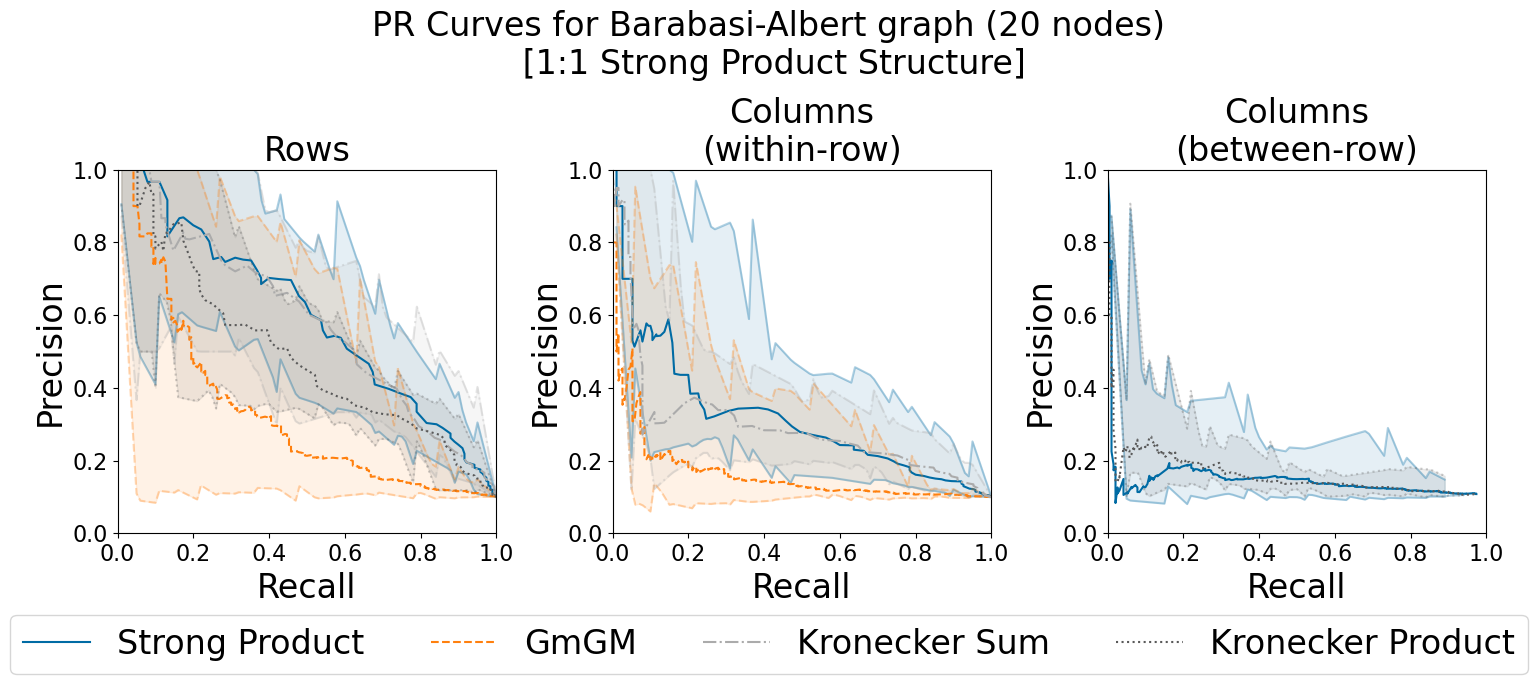

In [9]:
# This is a quick tester line to ensure the figure gets generated properly.
# Ignore it.

# Create a random graph
num_nodes = 20
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="1:1 Strong Product Structure",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1
)
fig.savefig("out_figs/synthetic/TEST-er.pdf", bbox_inches='tight')

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 0.02320727913613361
logm result may be inaccurate, approximate err = 0.0007418753428856647
logm result may be inaccurate, approximate err = 4.4744625149062444e-05
logm result may be inaccurate, approximate err = 4.5304822575021056e-05
logm result may be inaccurate, approximate err = 1.196264647447809e-05
logm result may be inaccurate, approximate err = 4.551834190858594e-05
logm result may be inaccurate, approximate err = 1.3740802397825897e-06
logm result may be inaccurate, approximate err = 1.3741367900742943e-06
logm result may be inaccurate, approximate err = 4.5531842140355885e-05
logm result may be inaccurate, approximate err = 4.0240232284480056e-05
logm result may be inaccurate, approximate err = 1.3741494606581414e-06
	Trial 2 of 10
logm result may be inaccurate, approximate err = 0.023489344190730316
logm result may be inaccurate, approximate err = 0.012554619946517152
logm result may be in

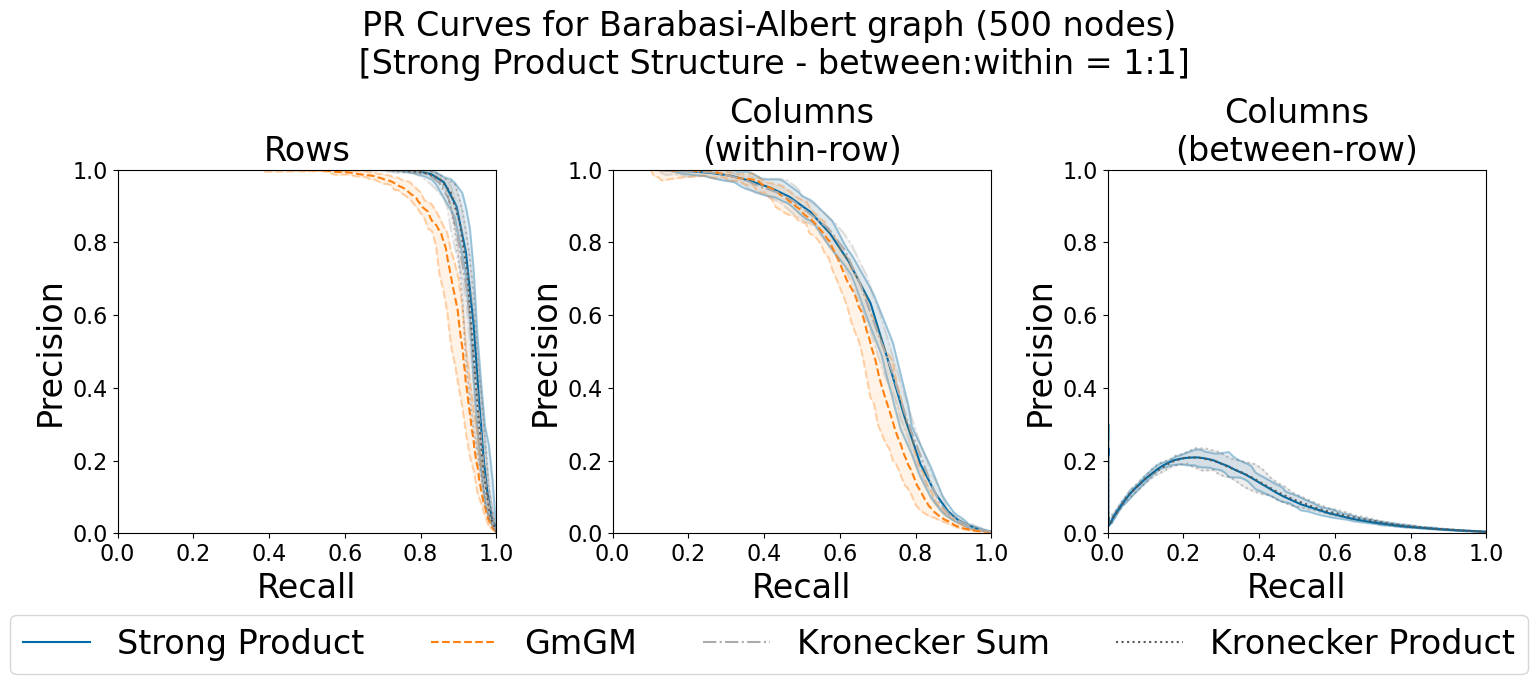

In [10]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 1:1",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1
)
fig.savefig('./out_figs/synthetic/sp1_500_nodes_1to1-er.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 0.024144288625115723
logm result may be inaccurate, approximate err = 4.4717492346405574e-05
logm result may be inaccurate, approximate err = 1.2576418917901984e-06
logm result may be inaccurate, approximate err = 4.52412564523515e-05
logm result may be inaccurate, approximate err = 2.1064821618580815e-05
logm result may be inaccurate, approximate err = 4.5366150433807825e-05
logm result may be inaccurate, approximate err = 1.268423408871494e-06
logm result may be inaccurate, approximate err = 4.538932498355678e-05
logm result may be inaccurate, approximate err = 4.5389646252165926e-05
logm result may be inaccurate, approximate err = 4.538972656485941e-05
logm result may be inaccurate, approximate err = 4.538976671796285e-05
logm result may be inaccurate, approximate err = 1.2685251706567852e-06
logm result may be inaccurate, approximate err = 4.53897918198116e-05
	Trial 2 of 10
logm result may be in

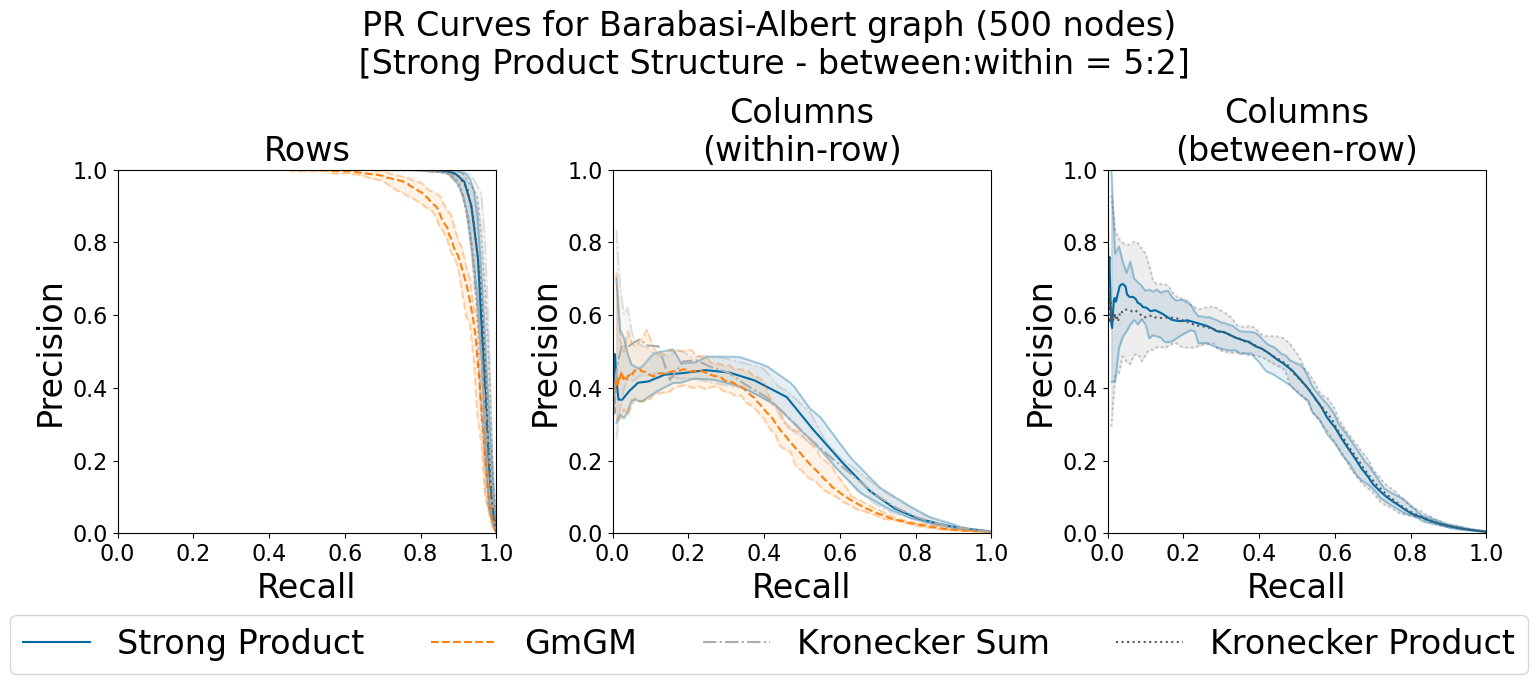

In [11]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 5:2",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5
)
fig.savefig('./out_figs/synthetic/sp1_500_nodes-er.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


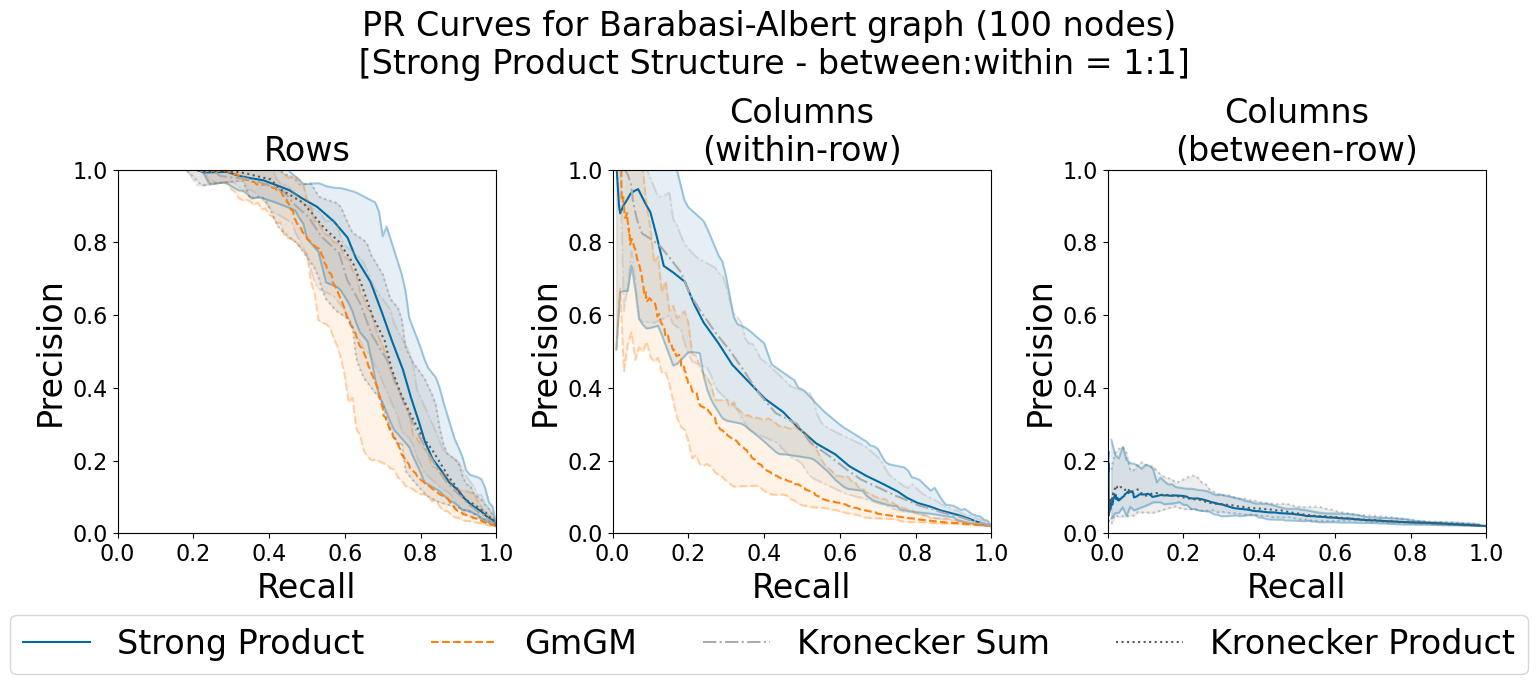

In [12]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 1:1",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1.0
)
fig.savefig('./out_figs/synthetic/sp1-er.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


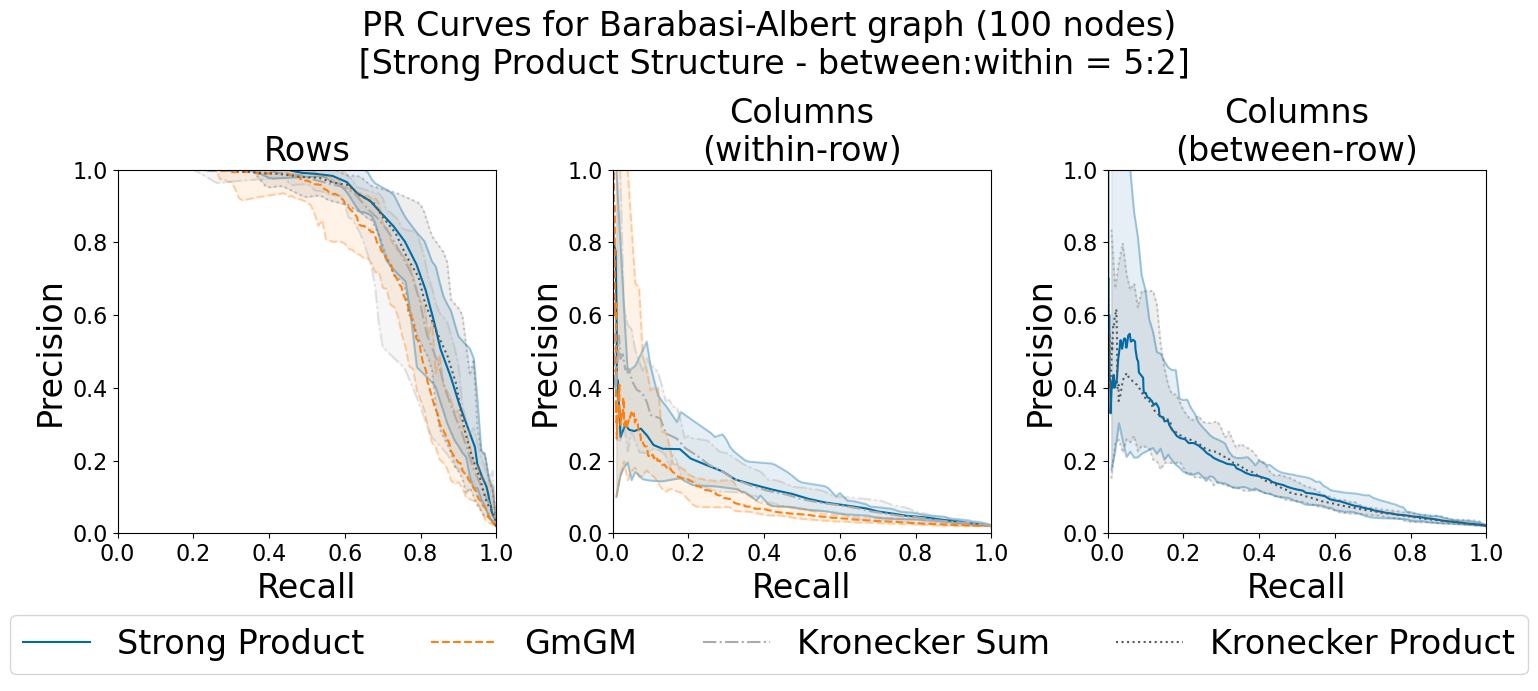

In [13]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 5:2",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5
)
fig.savefig('./out_figs/synthetic/sp5_2-er.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 4.349558770567393e-05
logm result may be inaccurate, approximate err = 4.361271078241215e-05
logm result may be inaccurate, approximate err = 3.258431590585688e-05
logm result may be inaccurate, approximate err = 4.3672730622743436e-05
logm result may be inaccurate, approximate err = 2.8522762396408724e-06
logm result may be inaccurate, approximate err = 1.2840036156519675e-05
	Trial 2 of 10
logm result may be inaccurate, approximate err = 4.392419315603772e-05
logm result may be inaccurate, approximate err = 4.309919921476937e-06
logm result may be inaccurate, approximate err = 2.265822907509788e-06
logm result may be inaccurate, approximate err = 4.406863458907928e-05
logm result may be inaccurate, approximate err = 4.389185410756368e-05
logm result may be inaccurate, approximate err = 4.407430261570153e-05
logm result may be inaccurate, approximate err = 2.266470769256385e-06
logm result may be in

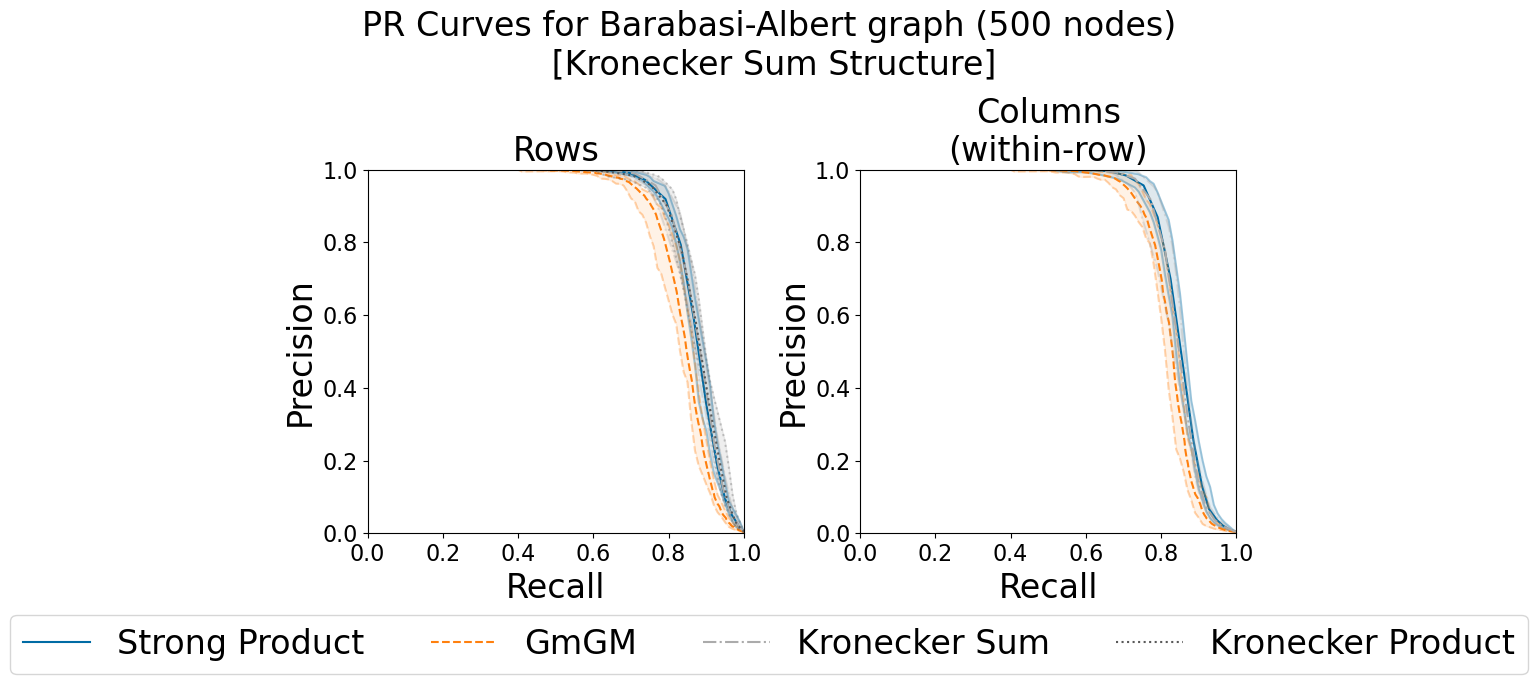

In [14]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Sum Structure",
    num_trials=10,
    model="Kronecker Sum"
)
fig.savefig('./out_figs/synthetic/ks_500-er.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


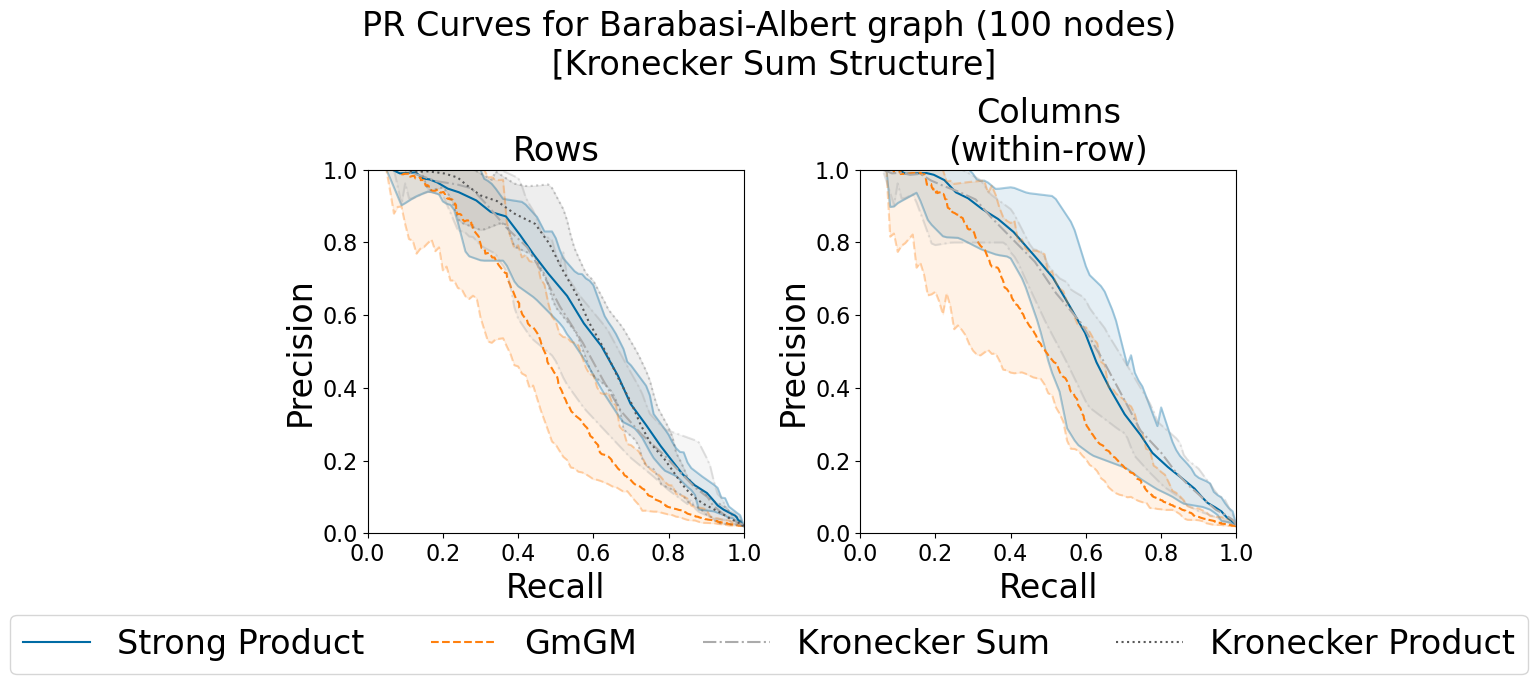

In [15]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Sum Structure",
    num_trials=10,
    model="Kronecker Sum"
)
fig.savefig('./out_figs/synthetic/ks-er.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 0.049742230322455804
logm result may be inaccurate, approximate err = 0.002070473650896404
logm result may be inaccurate, approximate err = 3.942131213395516e-05
logm result may be inaccurate, approximate err = 3.933262845453269e-05
logm result may be inaccurate, approximate err = 3.951982649515657e-05
logm result may be inaccurate, approximate err = 3.952184735010688e-05
logm result may be inaccurate, approximate err = 3.9522352416892176e-05
logm result may be inaccurate, approximate err = 3.9522478667438686e-05
logm result may be inaccurate, approximate err = 3.277648087573817e-05
logm result may be inaccurate, approximate err = 3.936889009674066e-05
logm result may be inaccurate, approximate err = 3.9522489521335575e-05
logm result may be inaccurate, approximate err = 4.154677723456342e-13
logm result may be inaccurate, approximate err = 2.07591386608767e-05
logm result may be inaccurate, approxim

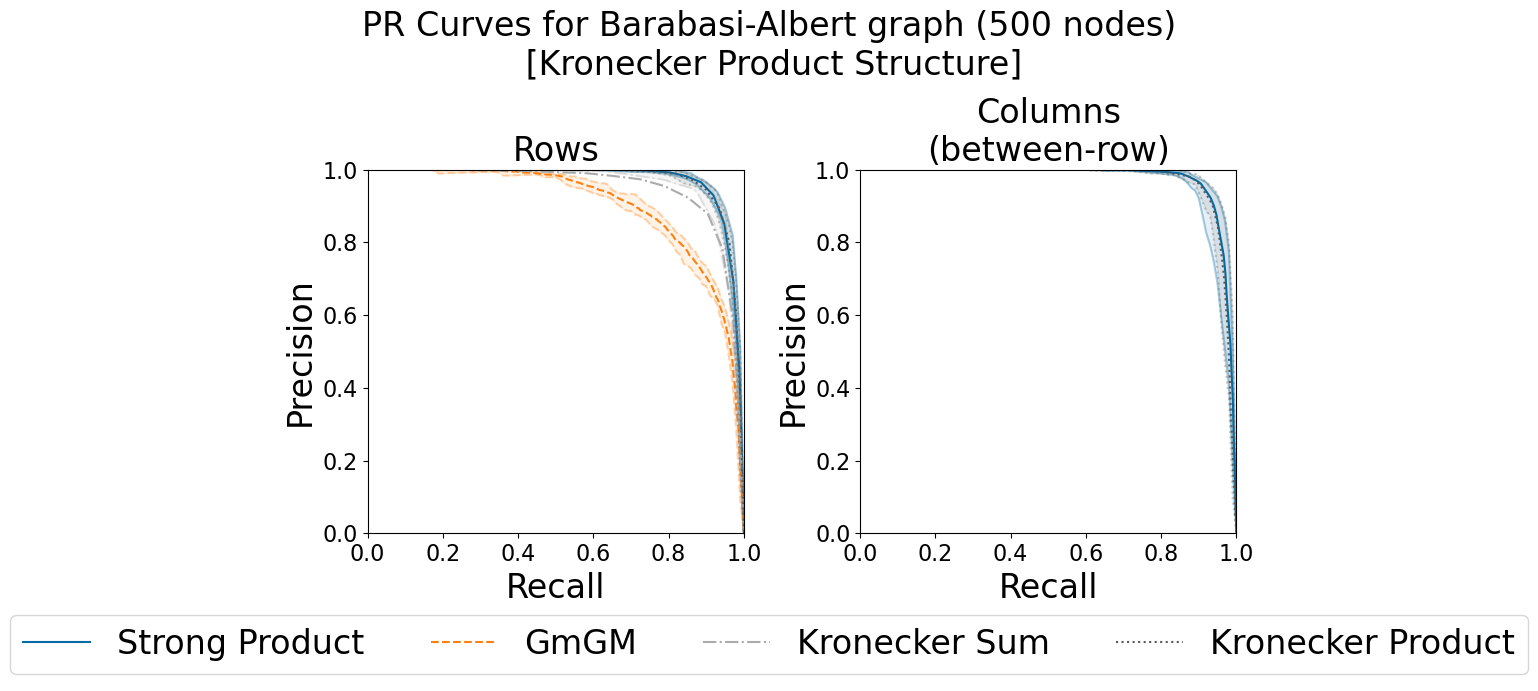

In [16]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Product Structure",
    num_trials=10,
    model="Kronecker Product"
)
fig.savefig('./out_figs/synthetic/kp_500-er.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


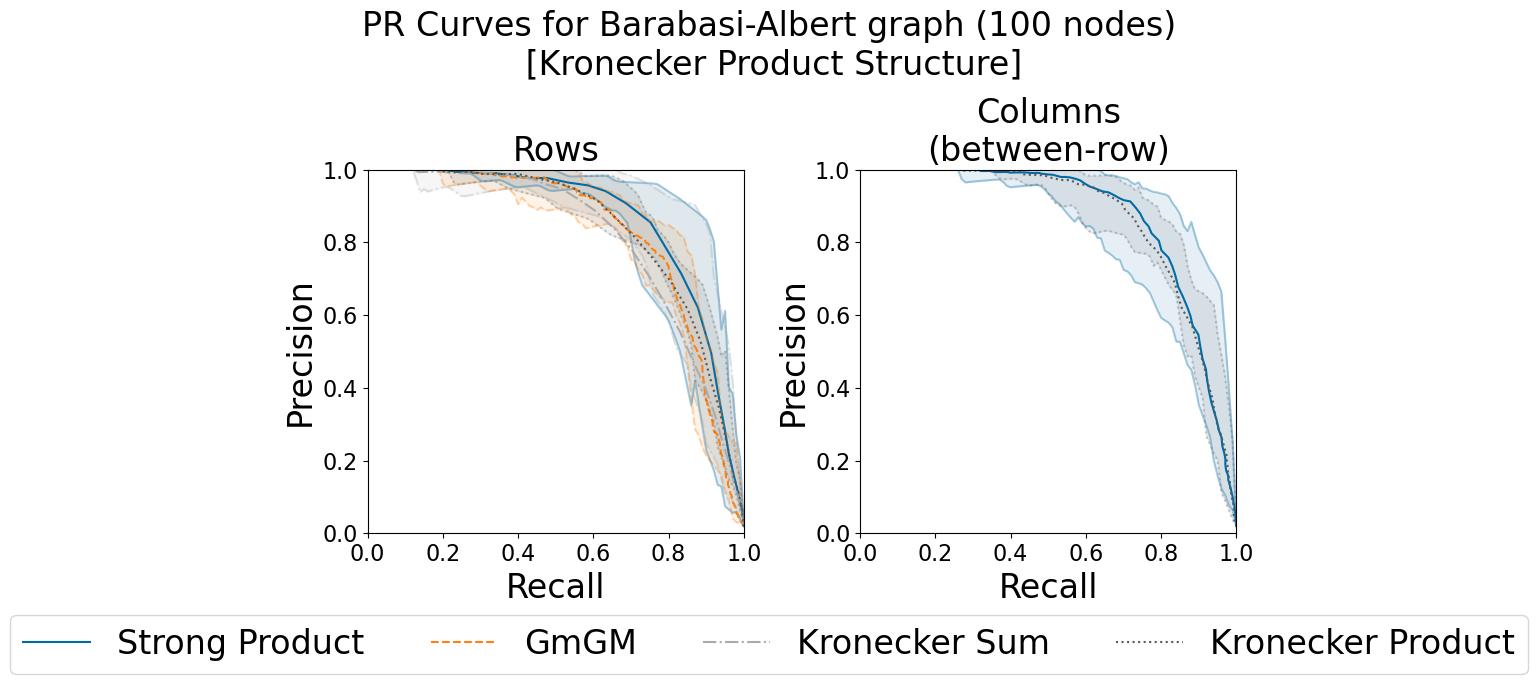

In [17]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph2 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
graph3 = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Product Structure",
    num_trials=10,
    model="Kronecker Product"
)
fig.savefig('./out_figs/synthetic/kp-er.pdf', bbox_inches="tight")